In [1]:
import numpy as np
import pandas as pd
from tqdm import trange 
import time
import os

In [2]:
df = pd.read_csv('group_call_HMS.csv')
df.head()

,call_start_day,call_start_time,call_end_day,call_end_time,hashed
0,1,09:14:58.558,1,09:41:30.200,967393e81d99ce8e577ee130b7ce8e4fd45e3e9cecb560...
1,17,11:05:05.176,17,13:07:42.515,02181a0c962f34f019bc9d5b582fb0ec79b1441f96aa4d...
2,20,02:18:43.172,20,02:28:58.177,86022904c5cf72a54978479c94041f4256d6c3c2a1f71c...
3,22,09:22:01.936,22,09:47:40.192,aafb40d212fe18ff4eafb82fdcf3b53f2161cb3ce59de4...
4,26,06:29:21.182,26,06:50:55.004,c87c2fad141edf323f3787335b54be22945a02fe052448...


In [3]:
len(df)

6962341

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962341 entries, 0 to 6962340
Data columns (total 5 columns):
call_start_day     int64
call_start_time    object
call_end_day       int64
call_end_time      object
hashed             object
dtypes: int64(2), object(3)
memory usage: 265.6+ MB


None

In [5]:
display(df.describe())

,call_start_day,call_end_day
count,6.962341e+06,6.962341e+06
mean,3.583216e+01,3.585883e+01
std,1.625579e+01,1.624768e+01
min,1.000000e+00,1.000000e+00
25%,2.300000e+01,2.300000e+01
50%,4.100000e+01,4.100000e+01
75%,5.000000e+01,5.000000e+01
max,5.600000e+01,5.700000e+01


# Preprocessing

In [6]:
hashed = []
hash_generator = (i for i in df['hashed'])
for i in trange(len(df)):
    t_h = next(hash_generator)
    split_hash = t_h.split(',')
    hashed.append(split_hash)

100%|████████████████████████████████████████████████████████████████████| 6962341/6962341 [00:14<00:00, 483511.65it/s]


In [7]:
df['hash_split'] = hashed 

# 전체 데이터 내에서 특정 hash 값이 몇 번 등장하는지 Count 

In [17]:
hash_generator = (i for i in df['hash_split'])
count_dict = {}
for i in trange(len(df)):
    t_h = next(hash_generator)
    for single_hash in t_h:
        if count_dict.get(single_hash) is not None:
            count_dict[single_hash] += 1
        else:
            count_dict[single_hash] = 0


100%|████████████████████████████████████████████████████████████████████| 6962341/6962341 [00:15<00:00, 456630.08it/s]


In [28]:
sort_count = sorted(count_dict.items(), key = lambda kv:kv[1], reverse= True)

In [35]:
print('Number of total ID :', len(sort_count))

Number of total ID : 268148


In [63]:
sort_count[:500]

[('a183c2b789eb249afbb85c17f7b45886ab5e9a36bc37929ecbf870eae6cc225a', 31497),
 ('9d6c5c34e7443b4ca86d47c05bee7116fb032e89a1c178194fc3623b2dbfc289', 29334),
 ('e7c75ecc843536c63aa2e11cd2c3b58eac270428ab53d5f6e5428e219d015068', 28970),
 ('8dafd5d19cfcd044348a6a7ec91745a1293bde2fedda59c16ce40fa6213ebdf6', 28807),
 ('3e48bcfcf37498565ec7639fe71feb05b7db71583f6141fe4a568fc3693f796e', 26118),
 ('8d61b7da9ca35ae0244834b1ea6b46ed58c2554132b153b02d012ce57b3df02d', 19158),
 ('87b164a488acac7674806cd33fb15f5a9d9d8f2008bd3507f6890482b2ebd53c', 5430),
 ('5c501cfe13b3e50065bec38d0bf347239904bf84bd8a28ad23de0ec1d2af224f', 2493),
 ('1f8eaf40ae57c75b371a182b2523be7cbf1650cf25e045104384efa510ad99e7', 2425),
 ('233e31dfaf8e935b814dbbfcf35960c4ceb2d608ea76541b2ab9f7fd63dc3f20', 2421),
 ('d37dd34efcd9029ac9d88e1a1fd42af8eee287ccd2b60bde73e63ea6e900ea1e', 2408),
 ('b9f04d25eff805b5ee7be77cf0849ae078ad3c2d9cf279fe25478abb2c818c76', 2274),
 ('3eee37c4d2f5cda2a86cafc6450c56fc618916b58c3cb580bd4889b86fdbcae0', 

(-100, 500)

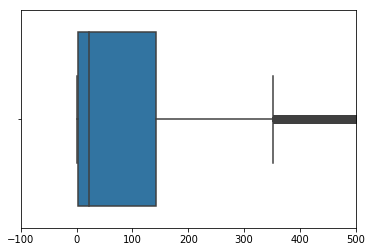

In [42]:
import seaborn as sns
%matplotlib inline
boxplot = sns.boxplot(x= [i[1] for i in sort_count])
ax = boxplot.axes
ax.set_xlim(-100,500)

#### 통화 참여횟수가 너무 편향되어 있어 boxplot 이 큰 의미가 없어 보입니다.

In [58]:
import numpy as np 
np.set_printoptions(precision=2)
count_list = [i[1] for i in sort_count]
print('Mean: {0:.0f} '.format(np.mean(count_list)))
print('Median: {0:.0f} '.format(np.median(count_list)))

Mean: 127 
Median: 23 


### 상위 n명에 대한 통화기록만 분석해봅시다. 

In [123]:
n = 10
important_id = [i[0] for i in sort_count[:n]]


## Build co-occurance matrix

In [124]:

#Intialization
d = {}
dict_idx = 0
important_call = []
hashed_generator = (i for i in df['hash_split'])

# Build dictionary 
for idx in trange(len(df['hash_split'])):
    save = False 
    t_h = next(hashed_generator)
    for source in t_h:
        if source not in important_id:
            continue 
        else:
            save = True
            break
    if save:
        important_call.append(idx)
        for source in t_h:
            if source not in d:
                d[source] = dict_idx
                dict_idx += 1


    



100%|████████████████████████████████████████████████████████████████████| 6962341/6962341 [00:09<00:00, 716216.62it/s]

In [125]:
print('Number of important calls that will be inspected: ',len(important_call))

Number of important calls that will be inspected:  67794


In [126]:
print('Number of total participants in the calls: ',len(d))

Number of total participants in the calls:  11898


#### 중요한 사람이 있는 call 기록만 저장되었는지 확인

In [127]:
for i in important_call:
    flag = False
    t_h = df['hash_split'].iloc[i]
    for idx, id_ in enumerate(important_id):
        if id_ in t_h:
            flag=True
            break
    if flag ==False :
        print('Error at call #' +str(i))
        

In [128]:
from tqdm import tqdm

In [129]:
from datetime import datetime
#Initializae matrix        
co_occurance_mtx = np.zeros((len(d),len(d)),dtype=int)
start_time = datetime.now()
hashed_generator = (i for i in df['hash_split'])

for i in tqdm(important_call):
    t_h = df['hash_split'].iloc[i]
    for idx2, source in enumerate(t_h):
        for target in t_h[idx2+1:]:
            co_occurance_mtx[d[source]][d[target]] += 1
end_time = datetime.now()
print('Duration:{}'.format(end_time-start_time)) 


100%|█████████████████████████████████████████████████████████████████████████| 67794/67794 [00:01<00:00, 59469.30it/s]

Duration:0:00:01.252651


In [133]:
co_occurance_mtx.shape

(11898, 11898)

### Edge file writer:
ID1, ID2, Weight 형태로 co-cocuraec matrix 에 있는 값을 저장한다.

In [135]:
from datetime import datetime
start_time = datetime.now()

threshold = 10
cnt = 0 


import csv
path_ = 'graph/temp.csv'
with open(path_, mode='w',encoding='utf8') as csv_file:
    writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['source','target','weight'])
    for i in trange(1,co_occurance_mtx.shape[0]):
        #print('Writing %d' %(i))
        for j in range(i):
            if co_occurance_mtx[i][j]>= threshold:
                cnt+=1
                writer.writerow([i,j,co_occurance_mtx[i][j]])
            
            
end_time = datetime.now()
print('Duration:{}'.format(end_time-start_time))


 65%|█████████████████████████████████████████████████▎                          | 7729/11897 [00:14<00:15, 271.42it/s]


 91%|████████████████████████████████████████████████████████████████████▌      | 10877/11897 [00:28<00:05, 191.92it/s]


100%|███████████████████████████████████████████████████████████████████████████| 11897/11897 [00:34<00:00, 349.30it/s]

Duration:0:00:34.068873


In [132]:
for i in important_id:
    print(d.get(i))

414
415
413
418
416
468
417
407
19
10
